Lasso, Ridge, Randomforest, ElasticNet, GradientBoostingRegressor, LGBM(dart), XGB(otherBoosting), AdaBoostRegressor

# 1. Import

In [1]:
# Basic Library
import os
import pandas as pd
import numpy as np
import pickle
from itertools import permutations, combinations
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer

# HP Tuning
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour, plot_optimization_history
from optuna.visualization import plot_parallel_coordinate, plot_slice, plot_param_importances

# Modeling
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
import xgboost as xgb

In [2]:
def create_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        print("Created Directory :", dir)
    else:
        print("Directory already existed :", dir)
create_dir("../pickle")
create_dir("../model")
create_dir("../submission")

Directory already existed : ../pickle
Directory already existed : ../model
Directory already existed : ../submission


In [3]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
submission = pd.read_csv("../data/sample_submission.csv")

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

In [4]:
rows_train = train.shape[0] # 주어진 train data의 row 수
rows_test = test.shape[0] # 주어진 test data의 row 수
num_trial = 100 # 파라미터 튜닝을 몇 번 진행하는지의 수
splits_hp = 5 # 파라미터 튜닝을 진행할 때의 kfold 수
splits_tr = 15 # 모델 트레이닝을 진행할 때의 kfold 수
basic_seed = 42 # default seed
num_seed_hp = 3 # 파라미터 튜닝 seed 개수
num_seed_tr = 10 # 트레이닝 seed 개수
sel_seed = 3 # 선택할 seed 개수

# 2. Preprocessing

In [5]:
train = train.replace(0.0, 0.1)
test = test.replace(0.0, 0.1)

In [6]:
scaler1 = StandardScaler()
scaler2 = MinMaxScaler()
scaler3 = QuantileTransformer()
def feature_num_scaler(train_df, test_df):
    for num_col in num_cols:
        
        scaler1.fit(train[[num_col]])
        train_df[num_col+'#scaler1'] = scaler1.transform(train[[num_col]])
        test_df[num_col+'#scaler1'] = scaler1.transform(test_df[[num_col]])
        
        scaler2.fit(train[[num_col]])
        train_df[num_col+'#scaler2'] = scaler2.transform(train[[num_col]])
        test_df[num_col+'#scaler2'] = scaler2.transform(test_df[[num_col]])
        
        scaler3.fit(train[[num_col]])
        train_df[num_col+'#scaler3'] = scaler3.transform(train[[num_col]])
        test_df[num_col+'#scaler3'] = scaler3.transform(test_df[[num_col]])
        
        train_df[num_col+'#log'] = np.log(train_df[num_col])
        test_df[num_col+'#log'] = np.log(test_df[num_col])
        
        train_df[num_col+'#log2'] = np.log2(train_df[num_col])
        test_df[num_col+'#log2'] = np.log2(test_df[num_col])
        
        train_df[num_col+'#log10'] = np.log10(train_df[num_col])
        test_df[num_col+'#log10'] = np.log10(test_df[num_col])

In [7]:
def feature_cat_generation(df):

    for cat_col in cat_cols:
        for num_col in num_cols:        
            new_name = cat_col + "#mean#" + num_col
            grouped = df.groupby(cat_col)[num_col].mean()
            df[new_name] = df[cat_col].map(grouped)

            new_name = cat_col + "#std#" + num_col
            grouped = df.groupby(cat_col)[num_col].std(ddof = 1)
            df[new_name] = df[cat_col].map(grouped)

            new_name = cat_col + "#var#" + num_col
            grouped = df.groupby(cat_col)[num_col].var(ddof = 1)
            df[new_name] = df[cat_col].map(grouped)

            new_name = cat_col + "#max#" + num_col
            grouped = df.groupby(cat_col)[num_col].max()
            df[new_name] = df[cat_col].map(grouped)

            new_name = cat_col + "#min#" + num_col
            grouped = df.groupby(cat_col)[num_col].min()
            df[new_name] = df[cat_col].map(grouped)

            new_name = cat_col + "#ptp#" + num_col
            grouped = df.groupby(cat_col)[num_col].agg(np.ptp)
            df[new_name] = df[cat_col].map(grouped)

            new_name = cat_col + "#median" + num_col
            grouped = df.groupby(cat_col)[num_col].median()
            df[new_name] = df[cat_col].map(grouped)

            new_name = cat_col + "#skew" + num_col
            grouped = df.groupby(cat_col)[num_col].skew()
            df[new_name] = df[cat_col].map(grouped)

            new_name = cat_col + "#percentile_10" + num_col
            grouped = df.groupby(cat_col)[num_col].agg(lambda x: np.percentile(x, 10))
            df[new_name] = df[cat_col].map(grouped)

            new_name = cat_col + "#percentile_60" + num_col
            grouped = df.groupby(cat_col)[num_col].agg(lambda x: np.percentile(x, 60))
            df[new_name] = df[cat_col].map(grouped)

            new_name = cat_col + "#percentile_90" + num_col
            grouped = df.groupby(cat_col)[num_col].agg(lambda x: np.percentile(x, 90))
            df[new_name] = df[cat_col].map(grouped)
    
    return df

In [8]:
cat_cols = []
num_cols = []
for col in train.columns:
    if train[col].dtypes=='object':
        cat_cols.append(col)
    elif train[col].dtypes=='float64':
        num_cols.append(col)

In [9]:
feature_num_scaler(train, test)

In [10]:
train = train.replace(0.0, 0.01)
test = test.replace(0.0, 0.01)

In [11]:
cat_cols = []
num_cols = []
for col in train.columns:
    if train[col].dtypes=='object':
        cat_cols.append(col)
    elif train[col].dtypes=='float64':
        num_cols.append(col)

In [12]:
for num_col_first in num_cols:
    for num_col_second in num_cols:
        if (num_col_first != num_col_second):
            train[num_col_first+'/'+num_col_second] = train[num_col_first] / train[num_col_second]
            train[num_col_first+'*'+num_col_second] = train[num_col_first] * train[num_col_second]
            test[num_col_first+'/'+num_col_second] = test[num_col_first] / test[num_col_second]
            test[num_col_first+'*'+num_col_second] = test[num_col_first] * test[num_col_second]

In [ ]:
# for num_col_first in num_cols:
#     for num_col_second in num_cols:
#         if ((num_col_first != num_col_second)&
#             (((train[num_col_second]<=0.001)&(train[num_col_second]>=-0.001)).sum()==0)&
#             (((test[num_col_second]<=0.001)&(test[num_col_second]>=-0.001)).sum()==0)):
#             train[num_col_first+'/'+num_col_second] = train[num_col_first] / train[num_col_second]
#             train[num_col_first+'*'+num_col_second] = train[num_col_first] * train[num_col_second]
#             test[num_col_first+'/'+num_col_second] = test[num_col_first] / test[num_col_second]
#             test[num_col_first+'*'+num_col_second] = test[num_col_first] * test[num_col_second]

In [13]:
feature_cat_generation(train)
feature_cat_generation(test)

,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Lenght#scaler1,Lenght#scaler2,...,Gender#std#Shell Weight#log10,Gender#var#Shell Weight#log10,Gender#max#Shell Weight#log10,Gender#min#Shell Weight#log10,Gender#ptp#Shell Weight#log10,Gender#medianShell Weight#log10,Gender#skewShell Weight#log10,Gender#percentile_10Shell Weight#log10,Gender#percentile_60Shell Weight#log10,Gender#percentile_90Shell Weight#log10
0,F,0.595,0.470,0.155,1.1210,0.4515,0.1780,0.1550,0.600176,0.723881,...,0.203919,0.041583,-0.070581,-1.602060,1.531479,-0.530178,-0.960625,-0.836841,-0.494850,-0.338662
1,M,0.580,0.450,0.150,0.9270,0.2760,0.1815,0.3600,0.475366,0.701493,...,0.270111,0.072960,-0.047208,-2.301030,2.253822,-0.559091,-1.900897,-0.939302,-0.510042,-0.349694
2,I,0.260,0.205,0.070,0.0970,0.0415,0.0190,0.0305,-2.187241,0.223881,...,0.374580,0.140310,-0.275724,-2.823909,2.548185,-0.945004,-1.136631,-1.522879,-0.866142,-0.610834
3,M,0.590,0.460,0.130,1.1020,0.4550,0.2055,0.3300,0.558572,0.716418,...,0.270111,0.072960,-0.047208,-2.301030,2.253822,-0.559091,-1.900897,-0.939302,-0.510042,-0.349694
4,F,0.595,0.465,0.140,1.1130,0.5175,0.2440,0.3050,0.600176,0.723881,...,0.203919,0.041583,-0.070581,-1.602060,1.531479,-0.530178,-0.960625,-0.836841,-0.494850,-0.338662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2919,I,0.170,0.105,0.035,0.0340,0.0120,0.0085,0.0050,-2.936099,0.089552,...,0.374580,0.140310,-0.275724,-2.823909,2.548185,-0.945004,-1.136631,-1.522879,-0.866142,-0.610834
2920,I,0.435,0.345,0.115,0.4180,0.2220,0.0735,0.1060,-0.731128,0.485075,...,0.374580,0.140310,-0.275724,-2.823909,2.548185,-0.945004,-1.136631,-1.522879,-0.866142,-0.610834
2921,I,0.570,0.450,0.135,0.7940,0.3815,0.1415,0.2450,0.392159,0.686567,...,0.374580,0.140310,-0.275724,-2.823909,2.548185,-0.945004,-1.136631,-1.522879,-0.866142,-0.610834
2922,I,0.460,0.350,0.120,0.4885,0.1930,0.1050,0.1550,-0.523112,0.522388,...,0.374580,0.140310,-0.275724,-2.823909,2.548185,-0.945004,-1.136631,-1.522879,-0.866142,-0.610834


In [18]:
train_lab = train.copy()
test_lab = test.copy()

for col in train_lab.columns:
    if train_lab[col].dtypes=='object':
        train_lab[col] = train_lab[col].astype('category')
        test_lab[col] = test_lab[col].astype('category')

train_lgb_x = train_lab.drop(['Target'], axis=1) # 데이터 나누기
train_lgb_y = train_lab['Target']
test_lgb_x = test_lab.copy()

print('Category Encoding Completed')

Category Encoding Completed


XGB

In [ ]:
(test==np.inf).sum().sum()

In [ ]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
submission = pd.read_csv("../data/sample_submission.csv")

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

In [ ]:
train = train.replace(0.0, 0.1)
test = test.replace(0.0, 0.1)

In [ ]:
cat_cols = []
num_cols = []
for col in train.columns:
    if train[col].dtypes=='object':
        cat_cols.append(col)
    elif train[col].dtypes=='float64':
        num_cols.append(col)

In [ ]:
feature_num_scaler(train, test)

In [ ]:
cat_cols = []
num_cols = []
for col in train.columns:
    if train[col].dtypes=='object':
        cat_cols.append(col)
    elif train[col].dtypes=='float64':
        num_cols.append(col)

In [ ]:
for num_col_first in num_cols:
    for num_col_second in num_cols:
        if (num_col_first != num_col_second)&((train[num_col_second]==0).sum()==0)&((test[num_col_second]==0).sum()==0):
            train[num_col_first+'/'+num_col_second] = train[num_col_first] / train[num_col_second]
            train[num_col_first+'*'+num_col_second] = train[num_col_first] * train[num_col_second]
            test[num_col_first+'/'+num_col_second] = test[num_col_first] / test[num_col_second]
            test[num_col_first+'*'+num_col_second] = test[num_col_first] * test[num_col_second]

In [ ]:
for col in test.columns:
        if (test[col]==-np.inf).sum()!=0:
            print(col)
            cond = test[col]==-np.inf
            print(test[cond])

In [ ]:
feature_cat_generation(train)
feature_cat_generation(test)

In [19]:
train_ohe = train.copy()
test_ohe = test.copy()

train_ohe = pd.get_dummies(train_ohe)
test_ohe = pd.get_dummies(test_ohe)

train_xgb_x = train_ohe.drop(['Target'], axis=1) # 데이터 나누기
train_xgb_y = train_ohe['Target']
test_xgb_x = test_ohe.copy()

print('One-Hot Encoding Completed')

One-Hot Encoding Completed


## 이상치 제거

In [ ]:
col_name = 'Whole Weight'

In [ ]:
high = train[col_name].mean() + 3*train[col_name].std()
low = train[col_name].mean() - 3*train[col_name].std()

In [ ]:
print("Highest allowed", high)
print("Lowest allowed", low)

In [ ]:
train[(train[col_name] > high) | (train[col_name] < low)]

In [ ]:
train = train[~(train[col_name] > high) & ~(train[col_name] < low)]

In [ ]:
train[col_name] = np.where(train[col_name]>high, high, np.where(train[col_name]<low, low, train[col_name]))

# 2. Modeling

In [20]:
pred_dict = {}
pred_test_dict = {}

## (1) LightGBM

In [21]:
train_x = train_lgb_x.copy()
train_y = train_lgb_y.copy()
test_x = test_lgb_x.copy()

In [22]:
def lgb_objective(trial: Trial) -> float:
    score_hp = []
    for seed_hp in np.random.randint(0, 1000, num_seed_hp):
        params_lgb = {
            "random_state": seed_hp,
            "verbosity": -1,
#             "metric": "mae",
            "n_estimators": 10000,
            "learning_rate": trial.suggest_loguniform("learning_rate", 2e-3, 1e-1), # default=0.1, range=[0,1]
            "max_depth": trial.suggest_int("max_depth", 3, 12), # default=-1
            "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1e+2), # default=0
            "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1e+2), # default=0
            "num_leaves": trial.suggest_int("num_leaves", 31, 5000), # default=31, range=(1,130172]
            "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.0, 1.0), # feature_fraction, default=1
            "subsample": trial.suggest_uniform("subsample", 0.0, 1.0), # bagging_fraction, default=1, range=[0,1]
            "subsample_freq": trial.suggest_int("subsample_freq", 1, 20), # bagging_freq, default=0
            "min_child_samples": trial.suggest_int("min_child_samples", 1, 40), # min_data_in_leaf, default=20 
#             "max_bin": trial.suggest_categoricacl("max_bin", [15, 31, 63, 127, 255]),
            "max_bin": trial.suggest_int("max_bin", 100, 500),
        }

        kfold = StratifiedKFold(n_splits=splits_hp, random_state=seed_hp, shuffle=True) # Cross-validation cv=5
        cv = np.zeros(rows_train)

        for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):

            x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
            y_train, y_val = train_y.iloc[train_idx].values, train_y.iloc[val_idx].values

            lgbmodel = LGBMRegressor(**params_lgb)
                                                                                            # 진행상황 보고싶을때 -1을 100으로
            lgbmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=30, verbose=-1) 
            cv[val_idx] = lgbmodel.predict(x_val)
            
        score_hp.append(mean_absolute_error(train_y, cv))
    
    np.mean(score_hp)
    return np.mean(score_hp)

In [ ]:
sampler = TPESampler(seed=basic_seed)
lgb_study = optuna.create_study(study_name="lgb_parameter_opt", direction="minimize", sampler=sampler)
lgb_study.optimize(lgb_objective, n_trials=num_trial)

lgb_best_hyperparams = lgb_study.best_trial.params
lgb_base_hyperparams = {'n_estimators':10000,
#                         'lambda_l1':lgb_best_hyperparams['reg_alpha'],
#                         'lambda_l2':lgb_best_hyperparams['reg_lambda']
                       }
lgb_best_hyperparams.update(lgb_base_hyperparams)

with open('../pickle/lgb_best_hyperparams.pickle', 'wb') as fw:
    pickle.dump(lgb_best_hyperparams, fw)
print("The best hyperparameters are:\n", lgb_best_hyperparams)

In [ ]:
# optuna.visualization.matplotlib.plot_param_importances(lgb_study);

In [ ]:
# optuna.visualization.matplotlib.plot_slice(lgb_study);

In [ ]:
with open('../pickle/lgb_best_hyperparams.pickle', 'rb') as fw:
    lgb_best_hyperparams = pickle.load(fw)

In [ ]:
lucky_seeds = np.random.randint(0, 1000, num_seed_tr)

for i, seed in enumerate(lucky_seeds):

    kfold = StratifiedKFold(n_splits=splits_tr, random_state=seed, shuffle=True) # CV 늘려가면서 하기
    cv = np.zeros(rows_train)
    pred_test = np.zeros(rows_test)

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
        
        x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx].values.ravel(), train_y.iloc[val_idx].values.ravel()

        lgbmodel = LGBMRegressor(**lgb_best_hyperparams)
        lgbmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=30, verbose=-1)
        
        cv[val_idx] = lgbmodel.predict(x_val)
        pred_test += lgbmodel.predict(test_x) / splits_tr
        
    pred_dict['lgb'+str(seed)] = cv
    pred_test_dict['lgb'+str(seed)] = pred_test
    print(f'seed {seed}', 'mean_absolute_error :', mean_absolute_error(train_y, cv))

## LGBM Dart

In [ ]:
# def lgbd_objective(trial: Trial) -> float:
#     score_hp = []
#     for seed_hp in np.random.randint(0, 1000, num_seed_hp):
#         params_lgbd = {
#             "random_state": basic_seed,
#             "verbosity": -1,
# #             "metric": "mae",
#             "n_estimators": 10000,
#             "boosting_type": "dart",
#             "learning_rate": trial.suggest_uniform("learning_rate", 0.01, 0.1), # default=0.1, range=[0,1]
# #             "learning_rate": trial.suggest_loguniform("learning_rate", 2e-3, 1e-1), # default=0.1, range=[0,1]
#             "max_depth": trial.suggest_int("max_depth", 3, 10), # default=-1
#             "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1e+2), # default=0
#             "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1e+2), # default=0
#             "num_leaves": trial.suggest_int("num_leaves", 31, 3000), # default=31, range=(1,130172]
#             "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.0, 1.0), # feature_fraction, default=1
#             "subsample": trial.suggest_uniform("subsample", 0.0, 1.0), # bagging_fraction, default=1, range=[0,1]
#             "subsample_freq": trial.suggest_int("subsample_freq", 1, 20), # bagging_freq, default=0
#             "min_child_samples": trial.suggest_int("min_child_samples", 1, 40), # min_data_in_leaf, default=20 
#             "max_bin": trial.suggest_int("max_bin", 100, 500),
#             "drop_rate": trial.suggest_uniform("drop_rate", 0, 1), # only in dart, default=0.1, range=[0,1]
#             "max_drop": trial.suggest_int("max_drop", 20, 100), # only in dart, default=50, range=[0,1]
#             "skip_drop": trial.suggest_uniform("skip_drop", 0, 1), # only in dart, default=0.5, range=[0,1]
#         }

#         kfold = StratifiedKFold(n_splits=splits_hp, random_state=seed_hp, shuffle=True) # Cross-validation cv=5
#         cv = np.zeros(rows_train)

#         for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):

#             x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
#             y_train, y_val = train_y.iloc[train_idx].values, train_y.iloc[val_idx].values

#             lgbdmodel = LGBMRegressor(**params_lgbd)
#                                                                                             # 진행상황 보고싶을때 -1을 100으로
#             lgbdmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=30, verbose=-1) 
#             cv[val_idx] = lgbdmodel.predict(x_val)
            
#         score_hp.append(mean_absolute_error(train_y, cv))
    
#     np.mean(score_hp)
#     return np.mean(score_hp)

In [ ]:
# sampler = TPESampler(seed=basic_seed)
# lgbd_study = optuna.create_study(study_name="lgbd_parameter_opt", direction="minimize", sampler=sampler)
# lgbd_study.optimize(lgbd_objective, n_trials=num_trial)

# lgbd_best_hyperparams = lgbd_study.best_trial.params
# lgbd_base_hyperparams = {'n_estimators':10000, "boosting_type": "dart",
# #                         'lambda_l1':lgbd_best_hyperparams['reg_alpha'],
# #                         'lambda_l2':lgbd_best_hyperparams['reg_lambda']
#                        }
# lgbd_best_hyperparams.update(lgbd_base_hyperparams)

# with open('../pickle/lgbd_best_hyperparams.pickle', 'wb') as fw:
#     pickle.dump(lgbd_best_hyperparams, fw)
# print("The best hyperparameters are:\n", lgbd_best_hyperparams)

## (2) XGBoost

In [24]:
train_x = train_xgb_x.copy()
train_y = train_xgb_y.copy()
test_x = test_xgb_x.copy()

In [25]:
def xgb_objective(trial: Trial) -> float:
    score_hp = []
    for seed_hp in np.random.randint(0, 1000, num_seed_hp):
        params_xgb = {
        "random_state": seed_hp,
        "verbose": None,
        "learning_rate": trial.suggest_loguniform("learning_rate", 2e-3, 1e-1), # eta, default=0.3, range=[0,1]
        "gamma": trial.suggest_loguniform("gamma", 1e-2, 1e+2), # min_split_loss, default=0, range=[0,∞]
        "max_depth": trial.suggest_int("max_depth", 4, 10), # default=5, range=[0,∞]
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10), #default=1
        "max_delta_step" : trial.suggest_int("max_delta_step", 0, 10), #default=0
        "subsample": trial.suggest_uniform("subsample", 0.0, 1.0), # default=1, range=(0,1]
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.0, 1.0), # default=1, range=(0,1]
        "colsample_bylevel": trial.suggest_uniform("colsample_bylevel", 0.0, 1.0), # default=1, range=(0,1]
        "colsample_bynode": trial.suggest_uniform("colsample_bynode", 0.0, 1.0), # default=1, range=(0,1]
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1e+2), # default=0, range=[0,∞]
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1e+2), # default=1, range=[0,∞]
        "max_bin": trial.suggest_int("max_bin", 100, 400),
        }

        kfold = StratifiedKFold(n_splits=splits_hp, random_state=seed_hp, shuffle=True) # Cross-validation cv=5
        cv = np.zeros(rows_train)

        for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):

            x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
            y_train, y_val = train_y.iloc[train_idx].values, train_y.iloc[val_idx].values
            
            dtrain = xgb.DMatrix(x_train, label=y_train)
            dvalid = xgb.DMatrix(x_val, label=y_val)
            watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
                                                                                                # 진행상황 보고싶을때 None을 100으로
            xgbmodel = xgb.train(params_xgb, dtrain, 100000, watchlist, early_stopping_rounds=30, verbose_eval=None)
            cv[val_idx] = xgbmodel.predict(dvalid)
            
        score_hp.append(mean_absolute_error(train_y, cv))
    
    np.mean(score_hp)
#     pred_hp_dict['lgb'+str(seed)] = cv
#     print(f'seed {seed}', 'mean_absolute_error :', mean_absolute_error(train_y, cv))
    
#     return mean_absolute_error(train_y, cv)
    return np.mean(score_hp)

In [ ]:
sampler = TPESampler(seed=basic_seed)
xgb_study = optuna.create_study(study_name="xgb_parameter_opt", direction="minimize", sampler=sampler)
xgb_study.optimize(xgb_objective, n_trials=num_trial)

xgb_best_hyperparams = xgb_study.best_trial.params
xgb_base_hyperparams = {"random_state": basic_seed}
xgb_best_hyperparams.update(xgb_base_hyperparams)

with open('../pickle/xgb_best_hyperparams.pickle', 'wb') as fw:
    pickle.dump(xgb_best_hyperparams, fw)
print("The best hyperparameters are:\n", xgb_best_hyperparams)

In [26]:
sampler = TPESampler(seed=basic_seed)
xgb_study = optuna.create_study(study_name="xgb_parameter_opt", direction="minimize", sampler=sampler)
xgb_study.optimize(xgb_objective, n_trials=num_trial)

xgb_best_hyperparams = xgb_study.best_trial.params
xgb_base_hyperparams = {"random_state": basic_seed}
xgb_best_hyperparams.update(xgb_base_hyperparams)

with open('../pickle/xgb_best_hyperparams.pickle', 'wb') as fw:
    pickle.dump(xgb_best_hyperparams, fw)
print("The best hyperparameters are:\n", xgb_best_hyperparams)

[I 2022-03-24 15:01:12,486] A new study created in memory with name: xgb_parameter_opt
[I 2022-03-24 15:39:47,294] Trial 0 finished with value: 1.5431852831615984 and parameters: {'learning_rate': 0.008656900442587762, 'gamma': 63.512210106407046, 'max_depth': 9, 'min_child_weight': 6, 'max_delta_step': 1, 'subsample': 0.15599452033620265, 'colsample_bytree': 0.05808361216819946, 'colsample_bylevel': 0.8661761457749352, 'colsample_bynode': 0.6011150117432088, 'reg_alpha': 6.79657809075816, 'reg_lambda': 0.012087541473056965, 'max_bin': 391}. Best is trial 0 with value: 1.5431852831615984.
[I 2022-03-24 15:43:06,150] Trial 1 finished with value: 1.5440498130947518 and parameters: {'learning_rate': 0.05191885100622529, 'gamma': 0.07068974950624607, 'max_depth': 5, 'min_child_weight': 2, 'max_delta_step': 3, 'subsample': 0.5247564316322378, 'colsample_bytree': 0.43194501864211576, 'colsample_bylevel': 0.2912291401980419, 'colsample_bynode': 0.6118528947223795, 'reg_alpha': 0.0361389427121

KeyboardInterrupt: 

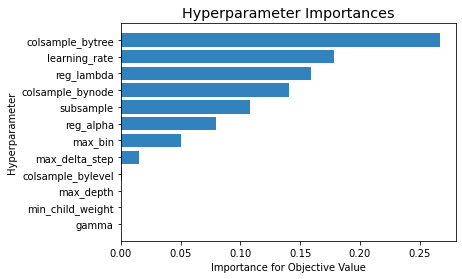

In [27]:
optuna.visualization.matplotlib.plot_param_importances(xgb_study);

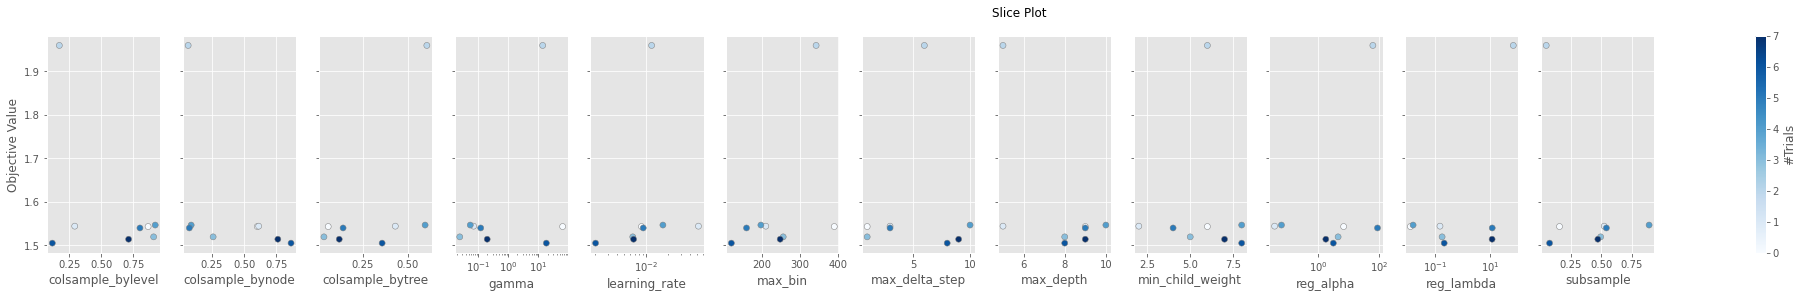

In [28]:
optuna.visualization.matplotlib.plot_slice(xgb_study);

In [ ]:
with open('../pickle/xgb_best_hyperparams.pickle', 'rb') as fw:
    xgb_best_hyperparams = pickle.load(fw)

In [ ]:
lucky_seeds = np.random.randint(0, 1000, num_seed_tr)
xgtest = xgb.DMatrix(test_x)
for i, seed in enumerate(lucky_seeds):

    kfold = StratifiedKFold(n_splits=splits_tr, random_state=seed, shuffle = True) # CV 늘려가면서 하기
    cv=np.zeros(rows_train)
    pred_test = np.zeros(rows_test)

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
        
        x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx].values.ravel(), train_y.iloc[val_idx].values.ravel()
        
        dtrain = xgb.DMatrix(x_train, label=y_train)
        dvalid = xgb.DMatrix(x_val, label=y_val)
        watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
                                                                                            # 진행상황 보고싶을때 None을 100으로
        xgbmodel = xgb.train(xgb_best_hyperparams, dtrain, 100000, watchlist, early_stopping_rounds=30, verbose_eval=None)

        cv[val_idx] = xgbmodel.predict(dvalid)
        pred_test += xgbmodel.predict(xgtest) / splits_tr # CV 바꾸면 이 숫자도 똑같이 바꿔야함
        
    pred_dict['xgb'+str(seed)] = cv
    pred_test_dict['xgb'+str(seed)] = pred_test
    print(f'seed {seed}', 'mean_absolute_error :', mean_absolute_error(train_y, cv))

# 3. Stacking

## (1) Collect Data

In [ ]:
def sort_dict(model, pred_dict, pred_test_dict):
    pred_dict_local = {}
    for key, value in pred_dict.items():
        if model in key:
            pred_dict_local[key]=value

    pred_test_dict_local = {}
    for key, value in pred_test_dict.items():
        if model in key:
            pred_test_dict_local[key]=value

    pred_dict_new_local = dict(sorted(
        pred_dict_local.items(), 
        key=lambda x:mean_absolute_error((train_y), list(x[1])), reverse=False)[:sel_seed])
    pred_test_dict_new_local = {}
    for key, value in pred_dict_new_local.items():
        pred_test_dict_new_local[key]=pred_test_dict_local[key]
        
    return pred_dict_new_local, pred_test_dict_new_local

In [ ]:
pred_dict_lgb, pred_test_dict_lgb = sort_dict('lgb', pred_dict, pred_test_dict)
pred_dict_xgb, pred_test_dict_xgb = sort_dict('xgb', pred_dict, pred_test_dict)

In [ ]:
def save_dict(model, pred_dict, pred_test_dict):
    with open('../pickle/pred_dict_'+model+'.pickle', 'wb') as fw:
        pickle.dump(pred_dict, fw)
    with open('../pickle/pred_test_dict_'+model+'.pickle', 'wb') as fw:
        pickle.dump(pred_test_dict, fw)

In [ ]:
save_dict('lgb', pred_dict_lgb, pred_test_dict_lgb)
save_dict('xgb', pred_dict_xgb, pred_test_dict_xgb)

In [ ]:
def load_dict(model):
    with open('../pickle/pred_dict_'+model+'.pickle', 'rb') as fw:
        pred_dict_new_local = pickle.load(fw)
    with open('../pickle/pred_test_dict_'+model+'.pickle', 'rb') as fw:
        pred_test_dict_new_local = pickle.load(fw)
    return pred_dict_new_local, pred_test_dict_new_local

In [ ]:
pred_dict_lgb, pred_test_dict_lgb = load_dict('lgb')
pred_dict_xgb, pred_test_dict_xgb = load_dict('xgb')

In [ ]:
pred_dict_total = {**pred_dict_lgb, **pred_dict_xgb}
pred_test_dict_total = {**pred_test_dict_lgb, **pred_test_dict_xgb}

## (2) HP Tuning

In [ ]:
def stack_objective(trial: Trial) -> float:
    score_hp = []
    for seed_hp in np.random.randint(0, 1000, 5):
        params_xgb = {
            "random_state": basic_seed,
            "verbose": None,
            "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1), # eta, default=0.3, range=[0,1]
            "gamma": trial.suggest_loguniform("gamma", 1e-2, 1e+2), # min_split_loss, default=0, range=[0,∞]
            "max_depth": trial.suggest_int("max_depth", 4, 10), # default=5, range=[0,∞]
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10), #default=1
            "max_delta_step" : trial.suggest_int("max_delta_step", 0, 10), #default=0
            "subsample": trial.suggest_uniform("subsample", 0.0, 1.0), # default=1, range=(0,1]
            "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.0, 1.0), # default=1, range=(0,1]
            "colsample_bylevel": trial.suggest_uniform("colsample_bylevel", 0.0, 1.0), # default=1, range=(0,1]
            "colsample_bynode": trial.suggest_uniform("colsample_bynode", 0.0, 1.0), # default=1, range=(0,1]
            "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1e+2), # default=0, range=[0,∞]
            "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1e+2), # default=1, range=[0,∞]
            "max_bin": trial.suggest_int("max_bin", 100, 400),
        }

        kfold = StratifiedKFold(n_splits=splits_hp, random_state=seed_hp, shuffle=True)
        cv = np.zeros(rows_train)

        for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):

            x_train, x_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train, y_val = train_y.iloc[train_idx], train_y.iloc[val_idx]

            dtrain = xgb.DMatrix(x_train, label=y_train)
            dvalid = xgb.DMatrix(x_val, label=y_val)
            watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
                                                                                                # 진행상황 보고싶을때 None을 100으로
            stack_xgbmodel = xgb.train(params_xgb, dtrain, 100000, watchlist, early_stopping_rounds=30, verbose_eval=None)
            cv[val_idx] = stack_xgbmodel.predict(dvalid)

        score_hp.append(mean_absolute_error(train_y, cv))
    
    np.mean(score_hp)
#     pred_hp_dict['lgb'+str(seed)] = cv
#     print(f'seed {seed}', 'mean_absolute_error :', mean_absolute_error(train_y, cv))
    
#     return mean_absolute_error(train_y, cv)
    return np.mean(score_hp)

In [ ]:
X_train = pd.DataFrame(np.vstack([x for _, x in pred_dict_total.items()]).T)
X_test = pd.DataFrame(np.vstack([x for _, x in pred_test_dict_total.items()]).T)

sampler = TPESampler(seed=basic_seed)
stack_study = optuna.create_study(study_name="stack_parameter_opt", direction="minimize", sampler=sampler)
stack_study.optimize(stack_objective, n_trials=num_trial)

stack_best_hyperparams = stack_study.best_trial.params
stack_base_hyperparams = {"random_state": basic_seed}
stack_best_hyperparams.update(stack_base_hyperparams)
print("The best hyperparameters are:\n", stack_best_hyperparams)

In [ ]:
# X_train = pd.DataFrame(np.vstack([x for _, x in pred_dict_total.items()]).T)
# X_test = pd.DataFrame(np.vstack([x for _, x in pred_test_dict_total.items()]).T)

# sampler = TPESampler(seed=basic_seed)
# stack_study = optuna.create_study(study_name="stack_parameter_opt", direction="minimize", sampler=sampler)
# stack_study.optimize(stack_objective, n_trials=num_trial)

# stack_best_hyperparams = stack_study.best_trial.params
# stack_base_hyperparams = {"random_state": basic_seed}
# stack_best_hyperparams.update(stack_base_hyperparams)

# with open('../pickle/stack_best_hyperparams.pickle', 'wb') as fw:
#     pickle.dump(stack_best_hyperparams, fw)
# print("The best hyperparameters are:\n", stack_best_hyperparams)

In [ ]:
# optuna.visualization.matplotlib.plot_param_importances(stack_study);

In [ ]:
# optuna.visualization.matplotlib.plot_slice(stack_study);

In [ ]:
with open('../pickle/stack_best_hyperparams.pickle', 'rb') as fw:
    stack_best_hyperparams = pickle.load(fw)

In [ ]:
pred = np.zeros(rows_train)
pred_test = np.zeros(rows_test)
kfold = StratifiedKFold(n_splits=splits_tr, random_state=basic_seed, shuffle = True)

for n, (train_idx, val_idx) in enumerate(kfold.split(X_train, train_y)):
    x_train, x_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train, y_val = train_y.iloc[train_idx], train_y.iloc[val_idx]

    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_val, label=y_val)
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
                                                                                        # 진행상황 보고싶을때 None을 100으로
    stack_xgbmodel = xgb.train(stack_best_hyperparams, dtrain, 100000, watchlist, early_stopping_rounds=30, verbose_eval=None)
    
    pred[val_idx] = stack_xgbmodel.predict(dvalid)
    pred_test += stack_xgbmodel.predict(xgb.DMatrix(X_test)) / splits_tr

In [ ]:
print(f'CV mean_absolute_error: {mean_absolute_error(train_y, pred):.6f}')

# 4. Blending

In [ ]:
stack_train = pred.copy()
stack_test = pred_test.copy()

In [ ]:
candidate = np.arange(0, 15)
permute = permutations(candidate, 3)
score = {}
for i in list(permute):
    pred_permute = (sum(pred_dict_lgb.values())/sel_seed * i[0] +
                  sum(pred_dict_xgb.values())/sel_seed * i[1] +
#               sum(pred_dict_cnn.values())/sel_seed * i[2] +
#               sum(pred_dict_rcnn.values())/sel_seed * i[3] +
                               stack_train * i[2])
    score[i] = mean_absolute_error(train_y, pred_permute/sum(i))

score = dict(sorted(score.items(), key=lambda x: x[1], reverse=False)[:5])
score

In [ ]:
pred = (sum(pred_dict_lgb.values())/sel_seed * list(score.keys())[0][0] +
        sum(pred_dict_xgb.values())/sel_seed * list(score.keys())[0][1] +
#         sum(pred_dict_cnn.values())/sel_seed * list(score.keys())[0][2] +
#         sum(pred_dict_rcnn.values())/sel_seed * list(score.keys())[0][3] +
        stack_train * list(score.keys())[0][2]
       ) / sum(list(score.keys())[0])
mean_absolute_error(train_y, pred)

In [ ]:
pred_test = (sum(pred_test_dict_lgb.values())/3 * list(score.keys())[0][0] +
             sum(pred_test_dict_xgb.values())/3 * list(score.keys())[0][1] +
#              sum(pred_test_dict_cnn.values())/3 * list(score.keys())[0][2] +
#              sum(pred_test_dict_rcnn.values())/3 * list(score.keys())[0][3] +
             stack_test * list(score.keys())[0][2]
            ) / sum(list(score.keys())[0])

In [ ]:
candidate = np.arange(0, 11)
permute = permutations(candidate,5)
score = {}
for i in list(permute):
    pred_permute = (sum(pred_dict_lgb.values())/sel_seed * i[0] +
                    sum(pred_dict_xgb.values())/sel_seed * i[1] +
                    sum(pred_dict_cnn.values())/sel_seed * i[2] +
                    sum(pred_dict_rcnn.values())/sel_seed * i[3] +
                    stack_train * i[4]
                   ) / 
    score[i] = mean_absolute_error(train_y, pred_permute/sum(i))

score = dict(sorted(score.items(), key=lambda x: x[1], reverse=False)[:5])
score

In [ ]:
pred = (sum(pred_dict_lgb.values())/sel_seed * list(score.keys())[0][0] +
        sum(pred_dict_xgb.values())/sel_seed * list(score.keys())[0][1] +
        sum(pred_dict_cnn.values())/sel_seed * list(score.keys())[0][2] +
        sum(pred_dict_rcnn.values())/sel_seed * list(score.keys())[0][3] +
        stack_train * list(score.keys())[0][4]
       ) / sum(list(score.keys())[0])
mean_absolute_error(train_y, pred)

In [ ]:
pred_test = (sum(pred_test_dict_lgb.values())/3 * list(score.keys())[0][0] +
             sum(pred_test_dict_xgb.values())/3 * list(score.keys())[0][1] +
             sum(pred_test_dict_cnn.values())/3 * list(score.keys())[0][2] +
             sum(pred_test_dict_rcnn.values())/3 * list(score.keys())[0][3] +
             stack_test * list(score.keys())[0][4]
            ) / sum(list(score.keys())[0])

# 5. Weight

In [ ]:
pred = (pred_dict['lgb493']+pred_dict['lgb112'])/2

In [ ]:
pred_test = (pred_test_dict['lgb493']+pred_test_dict['lgb112'])/2

In [ ]:
weight_dict = {}
for target in tqdm(np.arange(4, 17)):
    score_dict = {}
    for weight in np.linspace(0.7, 1.3, 601):
        score_dict[weight] = mean_absolute_error(train_y, np.where(((pred>target)&(pred<target+1)), pred*weight, pred))
    weight_dict[target] = min(score_dict,key=score_dict.get)

In [ ]:
for key, value in weight_dict.items():
    pred = np.where(((pred>key)&(pred<key+1)), pred*value, pred)
    pred_test = np.where(((pred_test>key)&(pred_test<key+1)), pred_test*value, pred_test)

In [ ]:
for key, value in weight_dict.items():
    pred = np.where(((pred>key)&(pred<key+1)), pred*value, pred)
    pred_test = np.where(((pred_test>key)&(pred_test<key+1)), pred_test*value, pred_test)
min_target = list(weight_dict.keys())[0]
max_target = list(weight_dict.keys())[-1]
min_weight = weight_dict[min_target]
max_weight = weight_dict[max_target]
pred = np.where(pred<min_target, pred*min_weight, pred)
pred = np.where(pred>max_target+1, pred*max_weight, pred)
pred_test = np.where(pred_test<min_target, pred_test*min_weight, pred_test)
pred_test = np.where(pred_test>max_target+1, pred_test*max_weight, pred_test)

In [ ]:
submission.Target = pred_test

In [ ]:
submission_name = '20220324'
submission_number = '1'
submission.to_csv(f'../submission/{submission_name}-{submission_number}.csv', index = False)